<a href="https://colab.research.google.com/github/muk465/CS6910-Fundamentals-of-Deeplearning/blob/main/Assignment2/PartA/guided_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#to get the dataset from url
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip \
      --no-check-certificate
#unzip the data set
!unzip nature_12K.zip



Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model

In [ ]:
# Assign training and validation set directories
import os
base_dir = '/content/inaturalist_12K'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

In [ ]:
model=tf.keras.models.load_model('./drive/MyDrive/Models/model_final')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 496, 496, 32)      2432      
                                                                 
 activation (Activation)     (None, 496, 496, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 496, 496, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 248, 248, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 248, 248, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 244, 244, 32)      2

In [ ]:
#the @tf.custom_gradient decorator to implement our own new guidedRelu function
#The differentiation function is a bidirectional ReLU function. 
#gradients from a deeper feature map is only passed through if it is greater than 0 and the initial feature map x from the forward pass was also greater than 0
@tf.custom_gradient
def guidedRelu(x):
    def grad(gradients):
        return tf.cast(gradients>0,tf.float32)  * tf.cast(x>0,tf.float32) * gradients
    return tf.nn.relu(x), grad

In [ ]:
#changing all relu to guidedrelu
for layer in model.layers:
  if hasattr(layer,'activation'):
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu

In [ ]:
layer_name = 'conv2d_4'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output[:,:,:,5])
intermediate_layer_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 500, 500, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 496, 496, 32)      2432      
                                                                 
 activation (Activation)     (None, 496, 496, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 496, 496, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 248, 248, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 248, 248, 32)      0   

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
#load img from test data
img_path = '/content/inaturalist_12K/val/Mammalia/1dbf119220e23080590712a2633b873f.jpg'
loaded_image = image.load_img(img_path, target_size=(500, 500))
input_img = image.img_to_array(loaded_image)
input_img = np.expand_dims(input_img, axis=0)

In [ ]:
def guided_backpropagation(neuron,input_img):
  layer_name = 'conv2d_4'
  intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output[:,:,:,neuron])
  #watch over the gradients of ip img 
  with tf.GradientTape() as tape:
      #convert img to tensor
      input_img=tf.cast(input_img,tf.float32)
      tape.watch(input_img)
      output = intermediate_layer_model(input_img)
  grad_img = tape.gradient(output, input_img).numpy()[0]
  return grad_img

In [ ]:
from matplotlib import pyplot as plt
neuron_list=[3,5,8,12,18,30,26,27,21,1]
images_guided_prop=[]
for n in neuron_list:
  images_guided_prop.append(guided_backpropagation(n,input_img))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

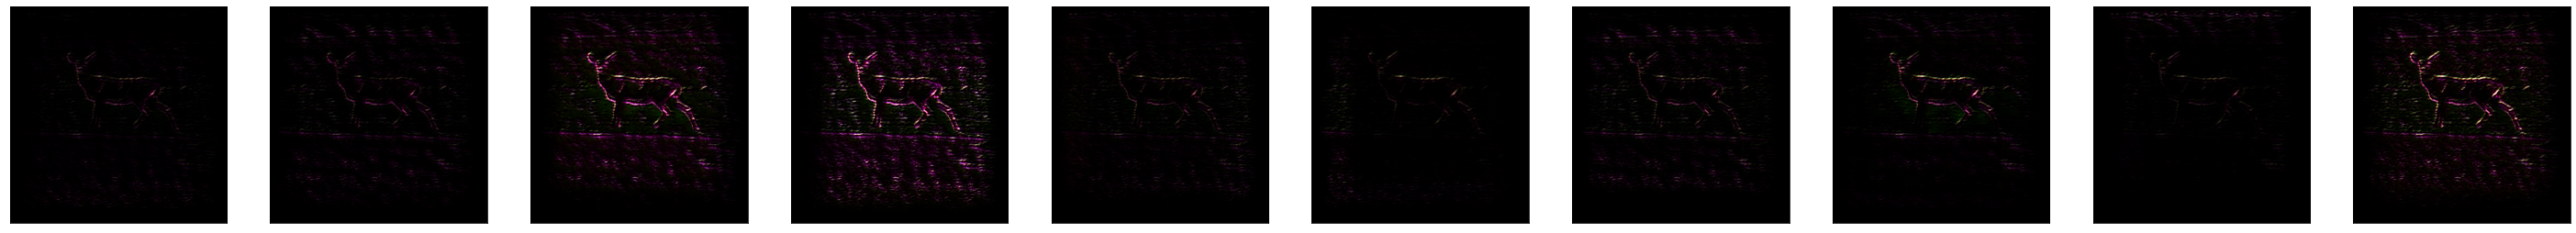

In [ ]:
plt.figure(figsize=(50,50))
columns = 10
rows = 1
for i in range(rows*columns):
    fig =plt.subplot(rows, columns, i+1)
    fig.set_xticks([])  #Turn off axis
    fig.set_yticks([])
    plt.imshow(images_guided_prop[i], cmap='gray')
plt.show()